# Advanced Wave Pattern Analysis Using Fractal Methods

## Overview
This analysis employs sophisticated mathematical techniques to understand wave behavior patterns at coastal monitoring stations. By combining wavelet analysis, Hurst exponent calculations, and statistical methods, we can reveal underlying patterns in wave behavior that might not be apparent through traditional analysis.

## Key Components

### 1. Time Series Analysis
- Tracks wave height variations over time
- Removes noise and handles missing data
- Provides baseline visualization of wave patterns

### 2. Wavelet Transform Analysis
- Decomposes wave patterns into different time scales
- Reveals periodic behaviors and anomalies
- Uses Mexican Hat wavelet for optimal pattern detection
- Visualizes time-frequency relationships in wave behavior

### 3. Hurst Exponent Analysis
The Hurst exponent (H) indicates the long-term memory of the time series:
- H < 0.5: Anti-persistent behavior (waves tend to reverse trends)
- H = 0.5: Random behavior (no clear pattern)
- H > 0.5: Persistent behavior (waves tend to follow trends)

### 4. Statistical Metrics
Key statistics provide context for wave behavior:
- Mean wave height
- Standard deviation
- Maximum and minimum values
- Pattern variability

## Applications

This analysis can be used for:
- Predicting dangerous wave conditions
- Understanding seasonal patterns
- Identifying unusual wave behavior
- Supporting maritime safety decisions
- Coastal engineering planning

## Interpretation Guide

The visualization dashboard provides four key views:
1. **Wave Height Time Series**: Shows raw wave height data over time
2. **Wavelet Transform**: Reveals patterns at different time scales
3. **Hurst Exponent**: Indicates the predictability of wave patterns
4. **Statistical Summary**: Provides key metrics for wave behavior

## Technical Implementation
- Built using Python scientific stack (NumPy, SciPy, PyWavelets)
- Implements R/S analysis for Hurst exponent calculation
- Uses continuous wavelet transform for pattern detection
- Handles real-time data from coastal monitoring stations

## Future Enhancements
- Machine learning integration for pattern prediction
- Real-time alert system for anomalous wave behavior
- Integration with weather data for comprehensive analysis
- Extended pattern recognition capabilities

In [14]:
import requests
import csv
from io import StringIO
import logging
import sqlite3
import pandas as pd
import numpy as np
from scipy import signal
from scipy.spatial import distance
from scipy.stats import linregress
import matplotlib.pyplot as plt
import pywt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [15]:
# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

BASE_URL = "https://www.ndbc.noaa.gov/data/realtime2/"

# Updated Stations relevant to Panama
STATIONS = {
    "42058": "Western Caribbean Sea",
    "32488": "Southwest Caribbean Sea",
    "43502": "East Pacific Ocean",
    "32411": "Eastern Pacific Ocean",
    "42039": "Caribbean Sea"
}


# SQLite database file
DB_FILE = "panama_surf.db"

def fetch_ndbc_data(station_id, data_type):
    url = f"{BASE_URL}{station_id}.{data_type}"
    try:
        response = requests.get(url)
        response.raise_for_status()
        return response.text
    except requests.RequestException as e:
        logging.error(f"Failed to fetch data for station {station_id}, type {data_type}: {e}")
        return None

def parse_data(raw_data, data_type):
    parsed_data = []
    csv_data = csv.reader(StringIO(raw_data), delimiter=' ', skipinitialspace=True)
    next(csv_data)  # Skip header
    next(csv_data)  # Skip units
    for row in csv_data:
        if data_type == "txt":
            parsed_data.append({
                "date": f"{row[0]}-{row[1]}-{row[2]}",
                "time": f"{row[3]}:00",
                "wind_dir": row[5],
                "wind_speed": row[6],
                "wave_height": row[8],
                "dominant_wave_period": row[9],
                "average_wave_period": row[10],
                "wave_direction": row[11],
                "sea_level_pressure": row[12],
                "air_temp": row[13],
                "sea_surface_temp": row[14],
            })
        elif data_type == "spec":
            parsed_data.append({
                "date": f"{row[0]}-{row[1]}-{row[2]}",
                "time": f"{row[3]}:00",
                "significant_wave_height": row[5],
                "swell_height": row[6],
                "swell_period": row[7],
                "wind_wave_height": row[8],
                "wind_wave_period": row[9],
                "swell_direction": row[10],
                "wind_wave_direction": row[11],
                "steepness": row[12],
                "average_wave_period": row[13],
            })
    return parsed_data

def create_table(conn, station_id, data_type):
    cur = conn.cursor()
    table_name = f"{station_id}_{data_type}"
    
    if data_type == "txt":
        cur.execute(f"""
            CREATE TABLE IF NOT EXISTS "{table_name}" (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                date TEXT,
                time TEXT,
                wind_dir TEXT,
                wind_speed TEXT,
                wave_height TEXT,
                dominant_wave_period TEXT,
                average_wave_period TEXT,
                wave_direction TEXT,
                sea_level_pressure TEXT,
                air_temp TEXT,
                sea_surface_temp TEXT
            )
        """)
    elif data_type == "spec":
        cur.execute(f"""
            CREATE TABLE IF NOT EXISTS "{table_name}" (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                date TEXT,
                time TEXT,
                significant_wave_height TEXT,
                swell_height TEXT,
                swell_period TEXT,
                wind_wave_height TEXT,
                wind_wave_period TEXT,
                swell_direction TEXT,
                wind_wave_direction TEXT,
                steepness TEXT,
                average_wave_period TEXT
            )
        """)
    conn.commit()

# Also update the store_data function to use quoted table names
def store_data(data, station_id, data_type):
    conn = sqlite3.connect(DB_FILE)
    create_table(conn, station_id, data_type)
    cur = conn.cursor()
    
    table_name = f"{station_id}_{data_type}"
    
    # Insert data
    for row in data:
        placeholders = ', '.join(['?' for _ in row])
        columns = ', '.join(f'"{col}"' for col in row.keys())
        sql = f'INSERT INTO "{table_name}" ({columns}) VALUES ({placeholders})'
        cur.execute(sql, list(row.values()))
    
    conn.commit()
    cur.close()
    conn.close()

# Update the get_data function as well
def get_data(station_id, data_type):
    conn = sqlite3.connect(DB_FILE)
    query = f'SELECT * FROM "{station_id}_{data_type}" ORDER BY date DESC, time DESC LIMIT 100'
    df = pd.read_sql_query(query, conn)
    conn.close()
    return df

In [3]:
# Fetch and store data for all stations and data types
# Move this function definition outside of any specific data processing block
def check_data_exists(station_id, data_type):
    conn = sqlite3.connect(DB_FILE)
    cur = conn.cursor()
    cur.execute(f"SELECT name FROM sqlite_master WHERE type='table' AND name='{station_id}_{data_type}'")
    exists = cur.fetchone() is not None
    conn.close()
    return exists

# Store active_stations as a global variable
active_stations = []

# Fetch and store data for all stations and data types
for station_id, location in STATIONS.items():
    station_active = False
    for data_type in ["txt", "spec"]:
        raw_data = fetch_ndbc_data(station_id, data_type)
        if raw_data:
            parsed_data = parse_data(raw_data, data_type)
            store_data(parsed_data, station_id, data_type)
            print(f"Data fetched and stored for {station_id} ({location}), type {data_type}")
            station_active = True
        else:
            print(f"Failed to fetch data for {station_id} ({location}), type {data_type}")
    if station_active:
        active_stations.append(station_id)

print(f"\nActive stations: {', '.join(active_stations)}")

# Example: Get and display recent data for station 42058
station_id = "42058"

# Check if data exists before trying to retrieve it
if check_data_exists(station_id, "txt") and check_data_exists(station_id, "spec"):
    txt_data = get_data(station_id, "txt")
    spec_data = get_data(station_id, "spec")

    print("Recent meteorological data:")
    display(txt_data.head())

    print("\nRecent spectral wave data:")
    display(spec_data.head())

    # Example: Plot wave height over time for station 42058
    plt.figure(figsize=(12, 6))
    plt.plot(pd.to_datetime(txt_data['date'] + ' ' + txt_data['time']), txt_data['wave_height'].astype(float))
    plt.title(f"Wave Height Over Time - Station {station_id}")
    plt.xlabel("Date and Time")
    plt.ylabel("Wave Height (m)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Example: Plot wind speed and direction for station 42058
    plt.figure(figsize=(12, 6))
    plt.scatter(txt_data['wind_dir'].astype(float), txt_data['wind_speed'].astype(float))
    plt.title(f"Wind Speed and Direction - Station {station_id}")
    plt.xlabel("Wind Direction (degrees)")
    plt.ylabel("Wind Speed (m/s)")
    plt.tight_layout()
    plt.show()
else:
    print(f"No data available for station {station_id}. Please ensure data has been fetched and stored.")

Data fetched and stored for 42058 (Western Caribbean Sea), type txt
Data fetched and stored for 42058 (Western Caribbean Sea), type spec


2024-10-26 15:28:05,455 - ERROR - Failed to fetch data for station 32488, type txt: 404 Client Error: Not Found for url: https://www.ndbc.noaa.gov/data/realtime2/32488.txt


Failed to fetch data for 32488 (Southwest Caribbean Sea), type txt


2024-10-26 15:28:05,843 - ERROR - Failed to fetch data for station 32488, type spec: 404 Client Error: Not Found for url: https://www.ndbc.noaa.gov/data/realtime2/32488.spec
2024-10-26 15:28:06,032 - ERROR - Failed to fetch data for station 43502, type txt: 404 Client Error: Not Found for url: https://www.ndbc.noaa.gov/data/realtime2/43502.txt


Failed to fetch data for 32488 (Southwest Caribbean Sea), type spec
Failed to fetch data for 43502 (East Pacific Ocean), type txt


2024-10-26 15:28:06,227 - ERROR - Failed to fetch data for station 43502, type spec: 404 Client Error: Not Found for url: https://www.ndbc.noaa.gov/data/realtime2/43502.spec
2024-10-26 15:28:06,421 - ERROR - Failed to fetch data for station 32411, type txt: 404 Client Error: Not Found for url: https://www.ndbc.noaa.gov/data/realtime2/32411.txt


Failed to fetch data for 43502 (East Pacific Ocean), type spec
Failed to fetch data for 32411 (Eastern Pacific Ocean), type txt


2024-10-26 15:28:06,621 - ERROR - Failed to fetch data for station 32411, type spec: 404 Client Error: Not Found for url: https://www.ndbc.noaa.gov/data/realtime2/32411.spec


Failed to fetch data for 32411 (Eastern Pacific Ocean), type spec


2024-10-26 15:28:06,846 - ERROR - Failed to fetch data for station 42039, type txt: 404 Client Error: Not Found for url: https://www.ndbc.noaa.gov/data/realtime2/42039.txt
2024-10-26 15:28:07,048 - ERROR - Failed to fetch data for station 42039, type spec: 404 Client Error: Not Found for url: https://www.ndbc.noaa.gov/data/realtime2/42039.spec


Failed to fetch data for 42039 (Caribbean Sea), type txt
Failed to fetch data for 42039 (Caribbean Sea), type spec

Active stations: 42058
Recent meteorological data:


,id,date,time,wind_dir,wind_speed,wave_height,dominant_wave_period,average_wave_period,wave_direction,sea_level_pressure,air_temp,sea_surface_temp
0,84812,2024-10-26,22:00,70,10.0,MM,MM,MM,MM,1008.9,30.4,30.4
1,32326,2024-10-26,21:00,70,9.0,2.2,7,5.3,102,1008.6,30.6,30.4
2,32327,2024-10-26,21:00,70,10.0,2.2,MM,5.3,102,1008.5,30.4,30.4
3,32328,2024-10-26,21:00,70,9.0,MM,MM,MM,MM,1008.5,30.4,30.4
4,38885,2024-10-26,21:00,70,10.0,MM,MM,MM,MM,1008.6,30.5,30.4



Recent spectral wave data:


,id,date,time,significant_wave_height,swell_height,swell_period,wind_wave_height,wind_wave_period,swell_direction,wind_wave_direction,steepness,average_wave_period
0,10814,2024-10-26,21:00,2.2,0.0,MM,2.2,7.1,MM,ESE,STEEP,5.3
1,13012,2024-10-26,21:00,2.2,0.0,MM,2.2,7.1,MM,ESE,STEEP,5.3
2,15210,2024-10-26,21:00,2.2,0.0,MM,2.2,7.1,MM,ESE,STEEP,5.3
3,17408,2024-10-26,21:00,2.2,0.0,MM,2.2,7.1,MM,ESE,STEEP,5.3
4,19606,2024-10-26,21:00,2.2,0.0,MM,2.2,7.1,MM,ESE,STEEP,5.3


ValueError: could not convert string to float: 'MM'

<Figure size 1200x600 with 0 Axes>

In [16]:
# Fetch and store data for all stations and data types
active_stations = []
for station_id, location in STATIONS.items():
    station_active = False
    for data_type in ["txt", "spec"]:
        raw_data = fetch_ndbc_data(station_id, data_type)
        if raw_data:
            parsed_data = parse_data(raw_data, data_type)
            store_data(parsed_data, station_id, data_type)
            print(f"Data fetched and stored for {station_id} ({location}), type {data_type}")
            station_active = True
        else:
            print(f"Failed to fetch data for {station_id} ({location}), type {data_type}")
    if station_active:
        active_stations.append(station_id)

print(f"\nActive stations: {', '.join(active_stations)}")

Data fetched and stored for 42058 (Western Caribbean Sea), type txt
Data fetched and stored for 42058 (Western Caribbean Sea), type spec


2024-10-26 16:07:26,619 - ERROR - Failed to fetch data for station 32488, type txt: 404 Client Error: Not Found for url: https://www.ndbc.noaa.gov/data/realtime2/32488.txt


Failed to fetch data for 32488 (Southwest Caribbean Sea), type txt


2024-10-26 16:07:27,007 - ERROR - Failed to fetch data for station 32488, type spec: 404 Client Error: Not Found for url: https://www.ndbc.noaa.gov/data/realtime2/32488.spec


Failed to fetch data for 32488 (Southwest Caribbean Sea), type spec


2024-10-26 16:07:27,494 - ERROR - Failed to fetch data for station 43502, type txt: 404 Client Error: Not Found for url: https://www.ndbc.noaa.gov/data/realtime2/43502.txt
2024-10-26 16:07:27,682 - ERROR - Failed to fetch data for station 43502, type spec: 404 Client Error: Not Found for url: https://www.ndbc.noaa.gov/data/realtime2/43502.spec


Failed to fetch data for 43502 (East Pacific Ocean), type txt
Failed to fetch data for 43502 (East Pacific Ocean), type spec


2024-10-26 16:07:27,871 - ERROR - Failed to fetch data for station 32411, type txt: 404 Client Error: Not Found for url: https://www.ndbc.noaa.gov/data/realtime2/32411.txt
2024-10-26 16:07:28,062 - ERROR - Failed to fetch data for station 32411, type spec: 404 Client Error: Not Found for url: https://www.ndbc.noaa.gov/data/realtime2/32411.spec


Failed to fetch data for 32411 (Eastern Pacific Ocean), type txt
Failed to fetch data for 32411 (Eastern Pacific Ocean), type spec


2024-10-26 16:07:28,274 - ERROR - Failed to fetch data for station 42039, type txt: 404 Client Error: Not Found for url: https://www.ndbc.noaa.gov/data/realtime2/42039.txt
2024-10-26 16:07:28,466 - ERROR - Failed to fetch data for station 42039, type spec: 404 Client Error: Not Found for url: https://www.ndbc.noaa.gov/data/realtime2/42039.spec


Failed to fetch data for 42039 (Caribbean Sea), type txt
Failed to fetch data for 42039 (Caribbean Sea), type spec

Active stations: 42058


In [17]:
# Function to plot data for a given station
def plot_station_data(station_id):
    if check_data_exists(station_id, "txt") and check_data_exists(station_id, "spec"):
        txt_data = get_data(station_id, "txt")
        spec_data = get_data(station_id, "spec")

        print(f"\nRecent meteorological data for station {station_id}:")
        display(txt_data.head())

        print(f"\nRecent spectral wave data for station {station_id}:")
        display(spec_data.head())

        # Plot wave height over time
        plt.figure(figsize=(12, 6))
        plt.plot(pd.to_datetime(txt_data['date'] + ' ' + txt_data['time']), txt_data['wave_height'].astype(float))
        plt.title(f"Wave Height Over Time - Station {station_id}")
        plt.xlabel("Date and Time")
        plt.ylabel("Wave Height (m)")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        # Plot wind speed and direction
        plt.figure(figsize=(12, 6))
        plt.scatter(txt_data['wind_dir'].astype(float), txt_data['wind_speed'].astype(float))
        plt.title(f"Wind Speed and Direction - Station {station_id}")
        plt.xlabel("Wind Direction (degrees)")
        plt.ylabel("Wind Speed (m/s)")
        plt.tight_layout()
        plt.show()
    else:
        print(f"No data available for station {station_id}.")

# Plot data for all active stations
for station_id in active_stations:
    plot_station_data(station_id)


Recent meteorological data for station 42058:


,id,date,time,wind_dir,wind_speed,wave_height,dominant_wave_period,average_wave_period,wave_direction,sea_level_pressure,air_temp,sea_surface_temp
0,84812,2024-10-26,22:00,70,10.0,MM,MM,MM,MM,1008.9,30.4,30.4
1,91375,2024-10-26,22:00,70,10.0,MM,MM,MM,MM,1008.9,30.4,30.4
2,97938,2024-10-26,22:00,70,10.0,MM,MM,MM,MM,1009.2,30.6,30.4
3,97939,2024-10-26,22:00,70,10.0,MM,MM,MM,MM,1009.1,30.5,30.4
4,97940,2024-10-26,22:00,70,10.0,2.2,8,5.3,101,1009.0,30.4,30.4



Recent spectral wave data for station 42058:


,id,date,time,significant_wave_height,swell_height,swell_period,wind_wave_height,wind_wave_period,swell_direction,wind_wave_direction,steepness,average_wave_period
0,32796,2024-10-26,22:00,2.2,0.6,13.8,2.1,7.7,E,E,STEEP,5.3
1,10814,2024-10-26,21:00,2.2,0.0,MM,2.2,7.1,MM,ESE,STEEP,5.3
2,13012,2024-10-26,21:00,2.2,0.0,MM,2.2,7.1,MM,ESE,STEEP,5.3
3,15210,2024-10-26,21:00,2.2,0.0,MM,2.2,7.1,MM,ESE,STEEP,5.3
4,17408,2024-10-26,21:00,2.2,0.0,MM,2.2,7.1,MM,ESE,STEEP,5.3


ValueError: could not convert string to float: 'MM'

<Figure size 1200x600 with 0 Axes>

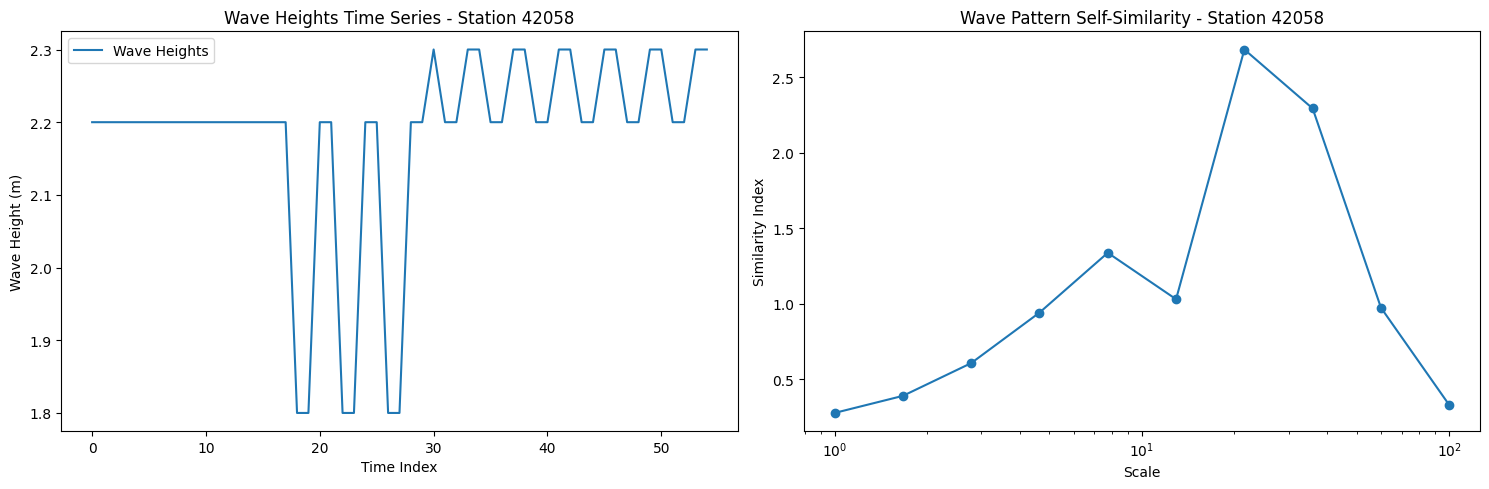

In [18]:
def analyze_coastal_patterns(station_id):
    """
    Analyze wave patterns for a given station using fractal analysis
    
    Parameters:
    station_id: ID of the station to analyze
    """
    try:
        if not check_data_exists(station_id, "txt") or not check_data_exists(station_id, "spec"):
            print(f"No data available for station {station_id}")
            return None
            
        txt_data = get_data(station_id, "txt")
        spec_data = get_data(station_id, "spec")
        
        # Convert wave height to numeric and handle missing values
        wave_heights = pd.to_numeric(txt_data['wave_height'], errors='coerce')
        wave_heights = wave_heights.dropna().values
        
        if len(wave_heights) < 2:
            print(f"Insufficient wave data for station {station_id}")
            return None
            
        results = {}
        
        # Analyze wave pattern self-similarity
        scales = np.logspace(0, 2, 10)
        similarities = wave_similarity_index(wave_heights, scales)
        results['wave_patterns'] = similarities
        
        # Visualize results
        visualize_results(results, station_id, wave_heights)
        
        return results
        
    except Exception as e:
        print(f"Error analyzing station {station_id}: {str(e)}")
        return None

def wave_similarity_index(wave_data, scales):
    """Calculate self-similarity index at different time scales using PyWavelets"""
    similarities = []
    for scale in scales:
        # Use continuous wavelet transform with Mexican Hat (same as Ricker) wavelet
        coeffs, _ = pywt.cwt(wave_data, [scale], 'mexh')
        similarities.append([scale, np.std(coeffs)])
    return np.array(similarities)

def visualize_results(results, station_id, wave_heights):
    """Generate visualizations for the analysis"""
    # Plot wave similarity analysis
    similarities = results['wave_patterns']
    
    plt.figure(figsize=(15, 5))
    
    # Plot 1: Wave Heights Time Series
    plt.subplot(121)
    plt.plot(wave_heights, label='Wave Heights')
    plt.title(f'Wave Heights Time Series - Station {station_id}')
    plt.xlabel('Time Index')
    plt.ylabel('Wave Height (m)')
    plt.legend()
    
    # Plot 2: Wave Pattern Self-Similarity
    plt.subplot(122)
    plt.plot(similarities[:,0], similarities[:,1], 'o-')
    plt.title(f'Wave Pattern Self-Similarity - Station {station_id}')
    plt.xlabel('Scale')
    plt.ylabel('Similarity Index')
    plt.xscale('log')
    
    plt.tight_layout()
    plt.show()

# Analyze patterns for all active stations
for station_id in active_stations:
    analyze_coastal_patterns(station_id)

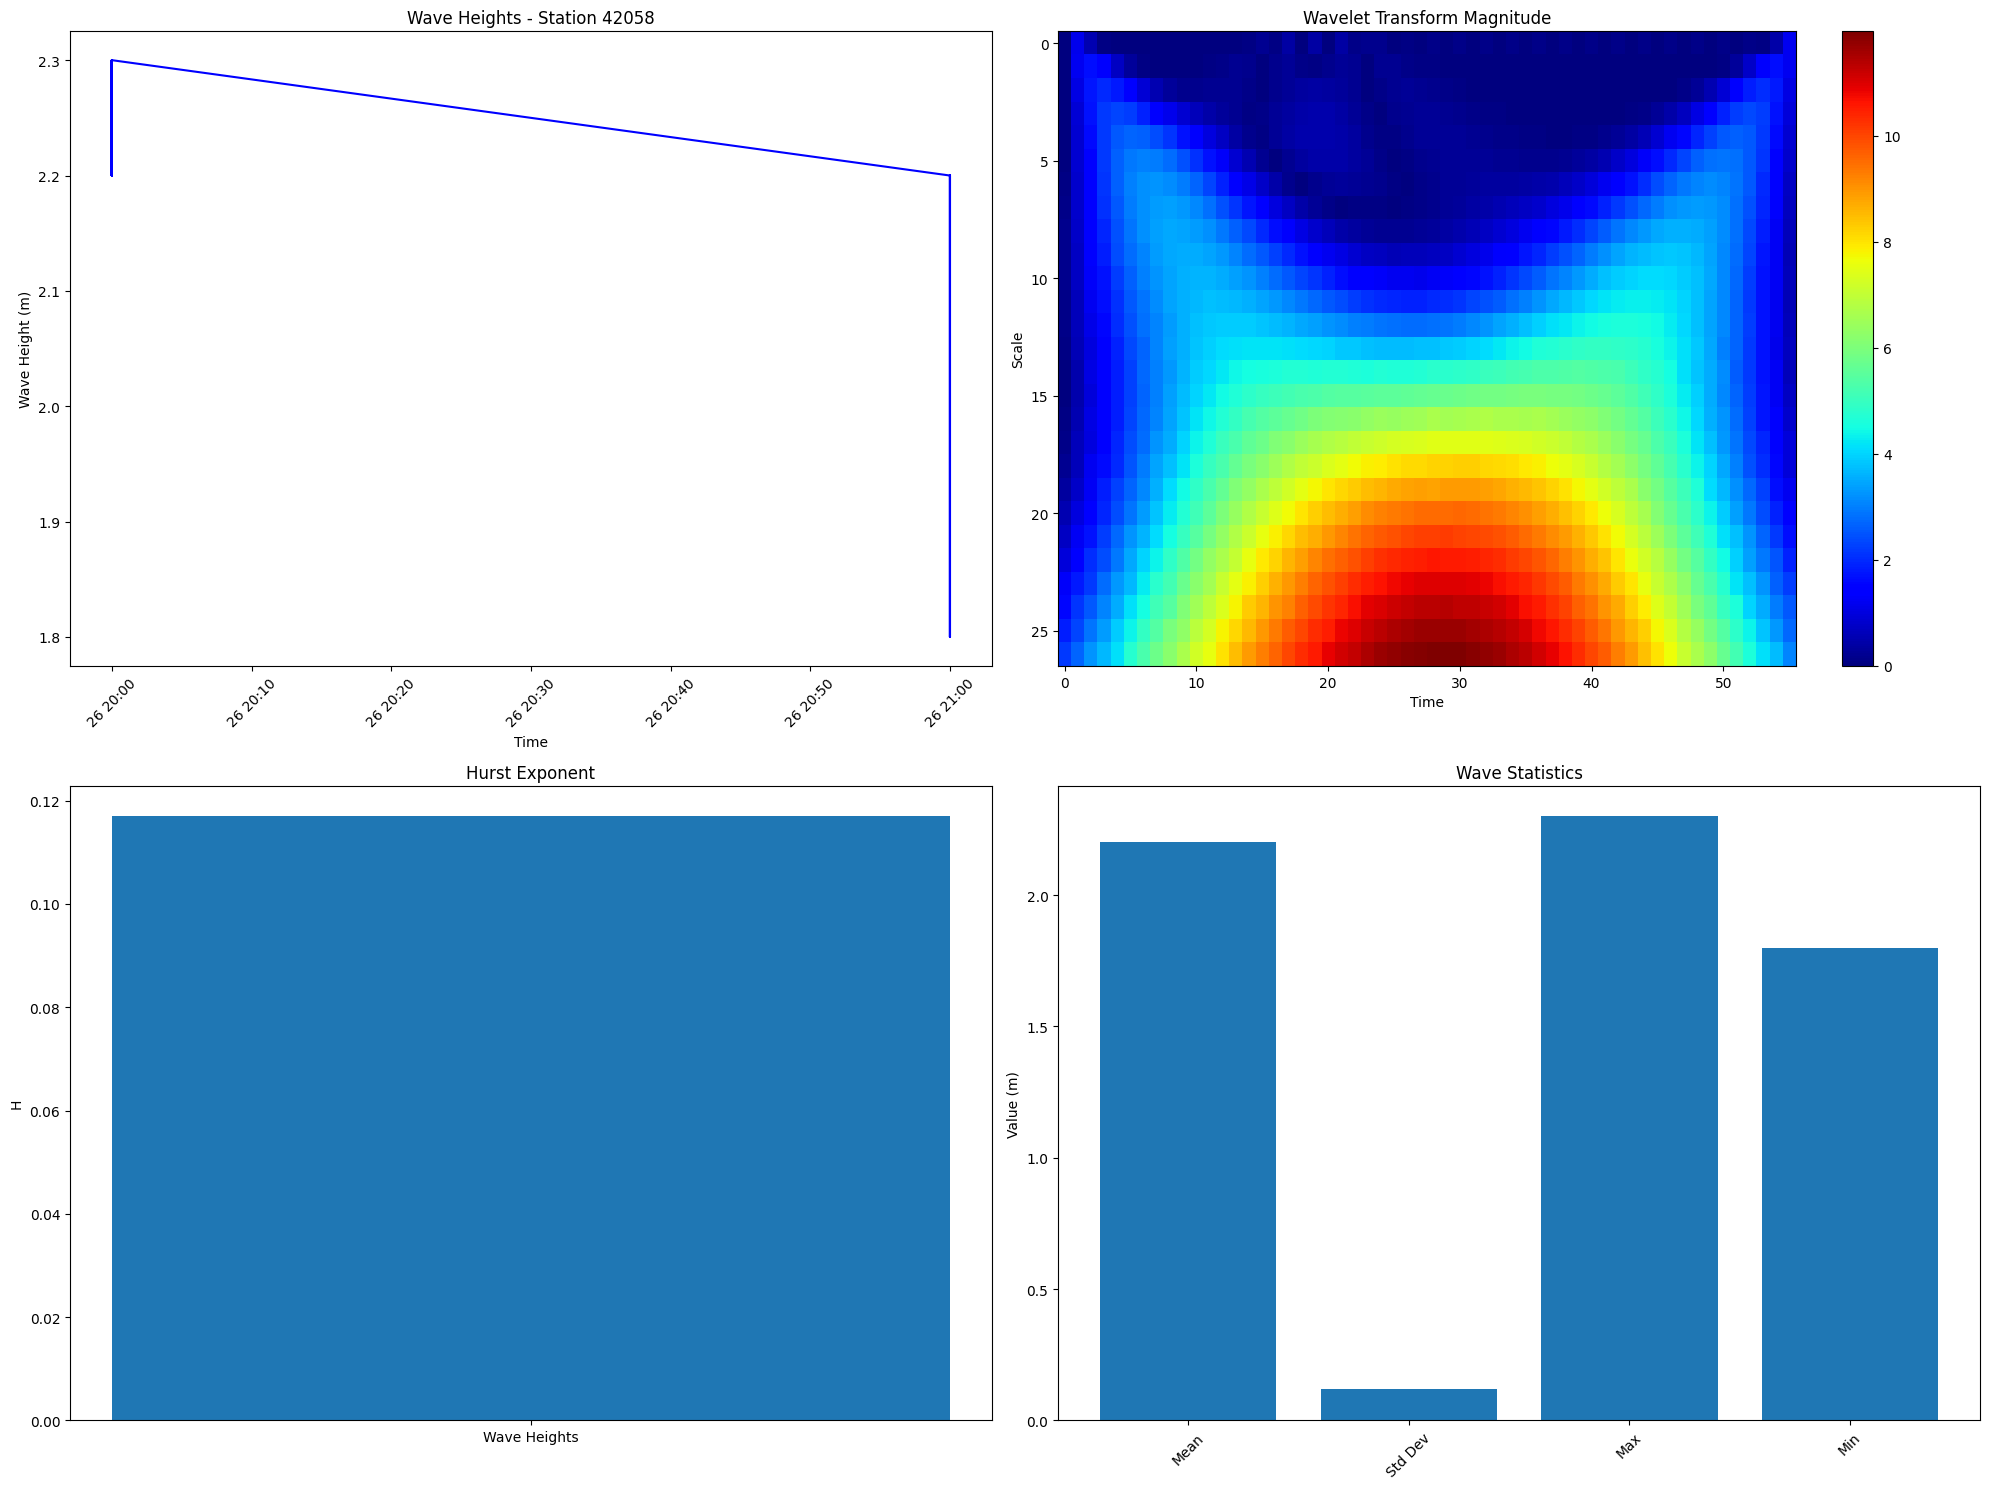


Hurst Exponent (H) for Station 42058: 0.117
Wave patterns show anti-persistent behavior (tendency to reverse)


In [9]:
class CoastalFractalAnalyzer:
    """Advanced analyzer for wave station data patterns"""
    
    def __init__(self, station_id):
        self.station_id = station_id
        self.waves = None
        self.timestamps = None
        self.load_data()
        self.scaler = StandardScaler()
    
    def load_data(self):
        """Load and prepare station data"""
        try:
            if check_data_exists(self.station_id, "txt"):
                txt_data = get_data(self.station_id, "txt")
                
                # Create a DataFrame with timestamps and wave heights
                df = pd.DataFrame({
                    'timestamp': pd.to_datetime(txt_data['date'] + ' ' + txt_data['time']),
                    'wave_height': pd.to_numeric(txt_data['wave_height'], errors='coerce')
                })
                
                # Drop NaN values and keep both columns aligned
                df = df.dropna(subset=['wave_height'])
                
                # Store the cleaned data
                self.waves = df['wave_height'].values
                self.timestamps = df['timestamp'].values
                
                if len(self.waves) < 2:
                    raise ValueError("Insufficient wave data")
                    
            else:
                raise ValueError(f"No data available for station {self.station_id}")
                
        except Exception as e:
            print(f"Error loading data for station {self.station_id}: {str(e)}")
            return None
    
    def calculate_hurst_exponent(self, data=None, max_lag=20):
        """Calculate Hurst exponent using R/S analysis"""
        if data is None:
            data = self.waves
            
        lags = range(2, max_lag)
        rs_values = []
        
        for lag in lags:
            rs = []
            for i in range(0, len(data)-lag, lag):
                segment = data[i:i+lag]
                r = np.max(segment) - np.min(segment)
                s = np.std(segment)
                if s > 0:
                    rs.append(r/s)
            if rs:
                rs_values.append(np.mean(rs))
        
        if len(rs_values) > 1:
            hurst = linregress(np.log(lags[:len(rs_values)]), 
                             np.log(rs_values))[0]
            return hurst
        return None
    
    def wavelet_analysis(self):
        """Perform wavelet analysis on wave data"""
        scales = np.arange(1, min(128, len(self.waves)//2))
        coeffs, freqs = pywt.cwt(self.waves, scales, 'mexh')
        return coeffs, scales
    
    def visualize_analysis(self):
        """Create comprehensive visualization of analyses"""
        fig = plt.figure(figsize=(20, 15))
        gs = fig.add_gridspec(2, 2)
        
        # Wave height time series
        ax1 = fig.add_subplot(gs[0, 0])
        ax1.plot(self.timestamps, self.waves, 'b-')
        ax1.set_title(f'Wave Heights - Station {self.station_id}')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Wave Height (m)')
        plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
        
        # Wavelet analysis
        coeffs, scales = self.wavelet_analysis()
        ax2 = fig.add_subplot(gs[0, 1])
        im = ax2.imshow(np.abs(coeffs), aspect='auto', cmap='jet')
        ax2.set_title('Wavelet Transform Magnitude')
        ax2.set_ylabel('Scale')
        ax2.set_xlabel('Time')
        plt.colorbar(im, ax=ax2)
        
        # Hurst exponent calculation
        h_wave = self.calculate_hurst_exponent()
        ax3 = fig.add_subplot(gs[1, 0])
        ax3.bar(['Wave Heights'], [h_wave])
        ax3.set_title('Hurst Exponent')
        ax3.set_ylabel('H')
        
        # Additional statistics
        ax4 = fig.add_subplot(gs[1, 1])
        stats_data = {
            'Mean': np.mean(self.waves),
            'Std Dev': np.std(self.waves),
            'Max': np.max(self.waves),
            'Min': np.min(self.waves)
        }
        ax4.bar(stats_data.keys(), stats_data.values())
        ax4.set_title('Wave Statistics')
        ax4.set_ylabel('Value (m)')
        plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45)
        
        plt.tight_layout()
        return fig

# Function to analyze a specific station
def analyze_station_patterns(station_id):
    """Analyze and visualize patterns for a single station"""
    try:
        # Create analyzer instance
        analyzer = CoastalFractalAnalyzer(station_id)
        
        # Generate and display visualizations
        fig = analyzer.visualize_analysis()
        plt.show()
        
        # Print Hurst exponent interpretation
        h_wave = analyzer.calculate_hurst_exponent()
        if h_wave is not None:
            print(f"\nHurst Exponent (H) for Station {station_id}: {h_wave:.3f}")
            if h_wave < 0.5:
                print("Wave patterns show anti-persistent behavior (tendency to reverse)")
            elif h_wave > 0.5:
                print("Wave patterns show persistent behavior (trend-following)")
            else:
                print("Wave patterns show random behavior")
                
    except Exception as e:
        print(f"Error analyzing station {station_id}: {str(e)}")

# Analyze patterns for all active stations
for station_id in active_stations:
    analyze_station_patterns(station_id)

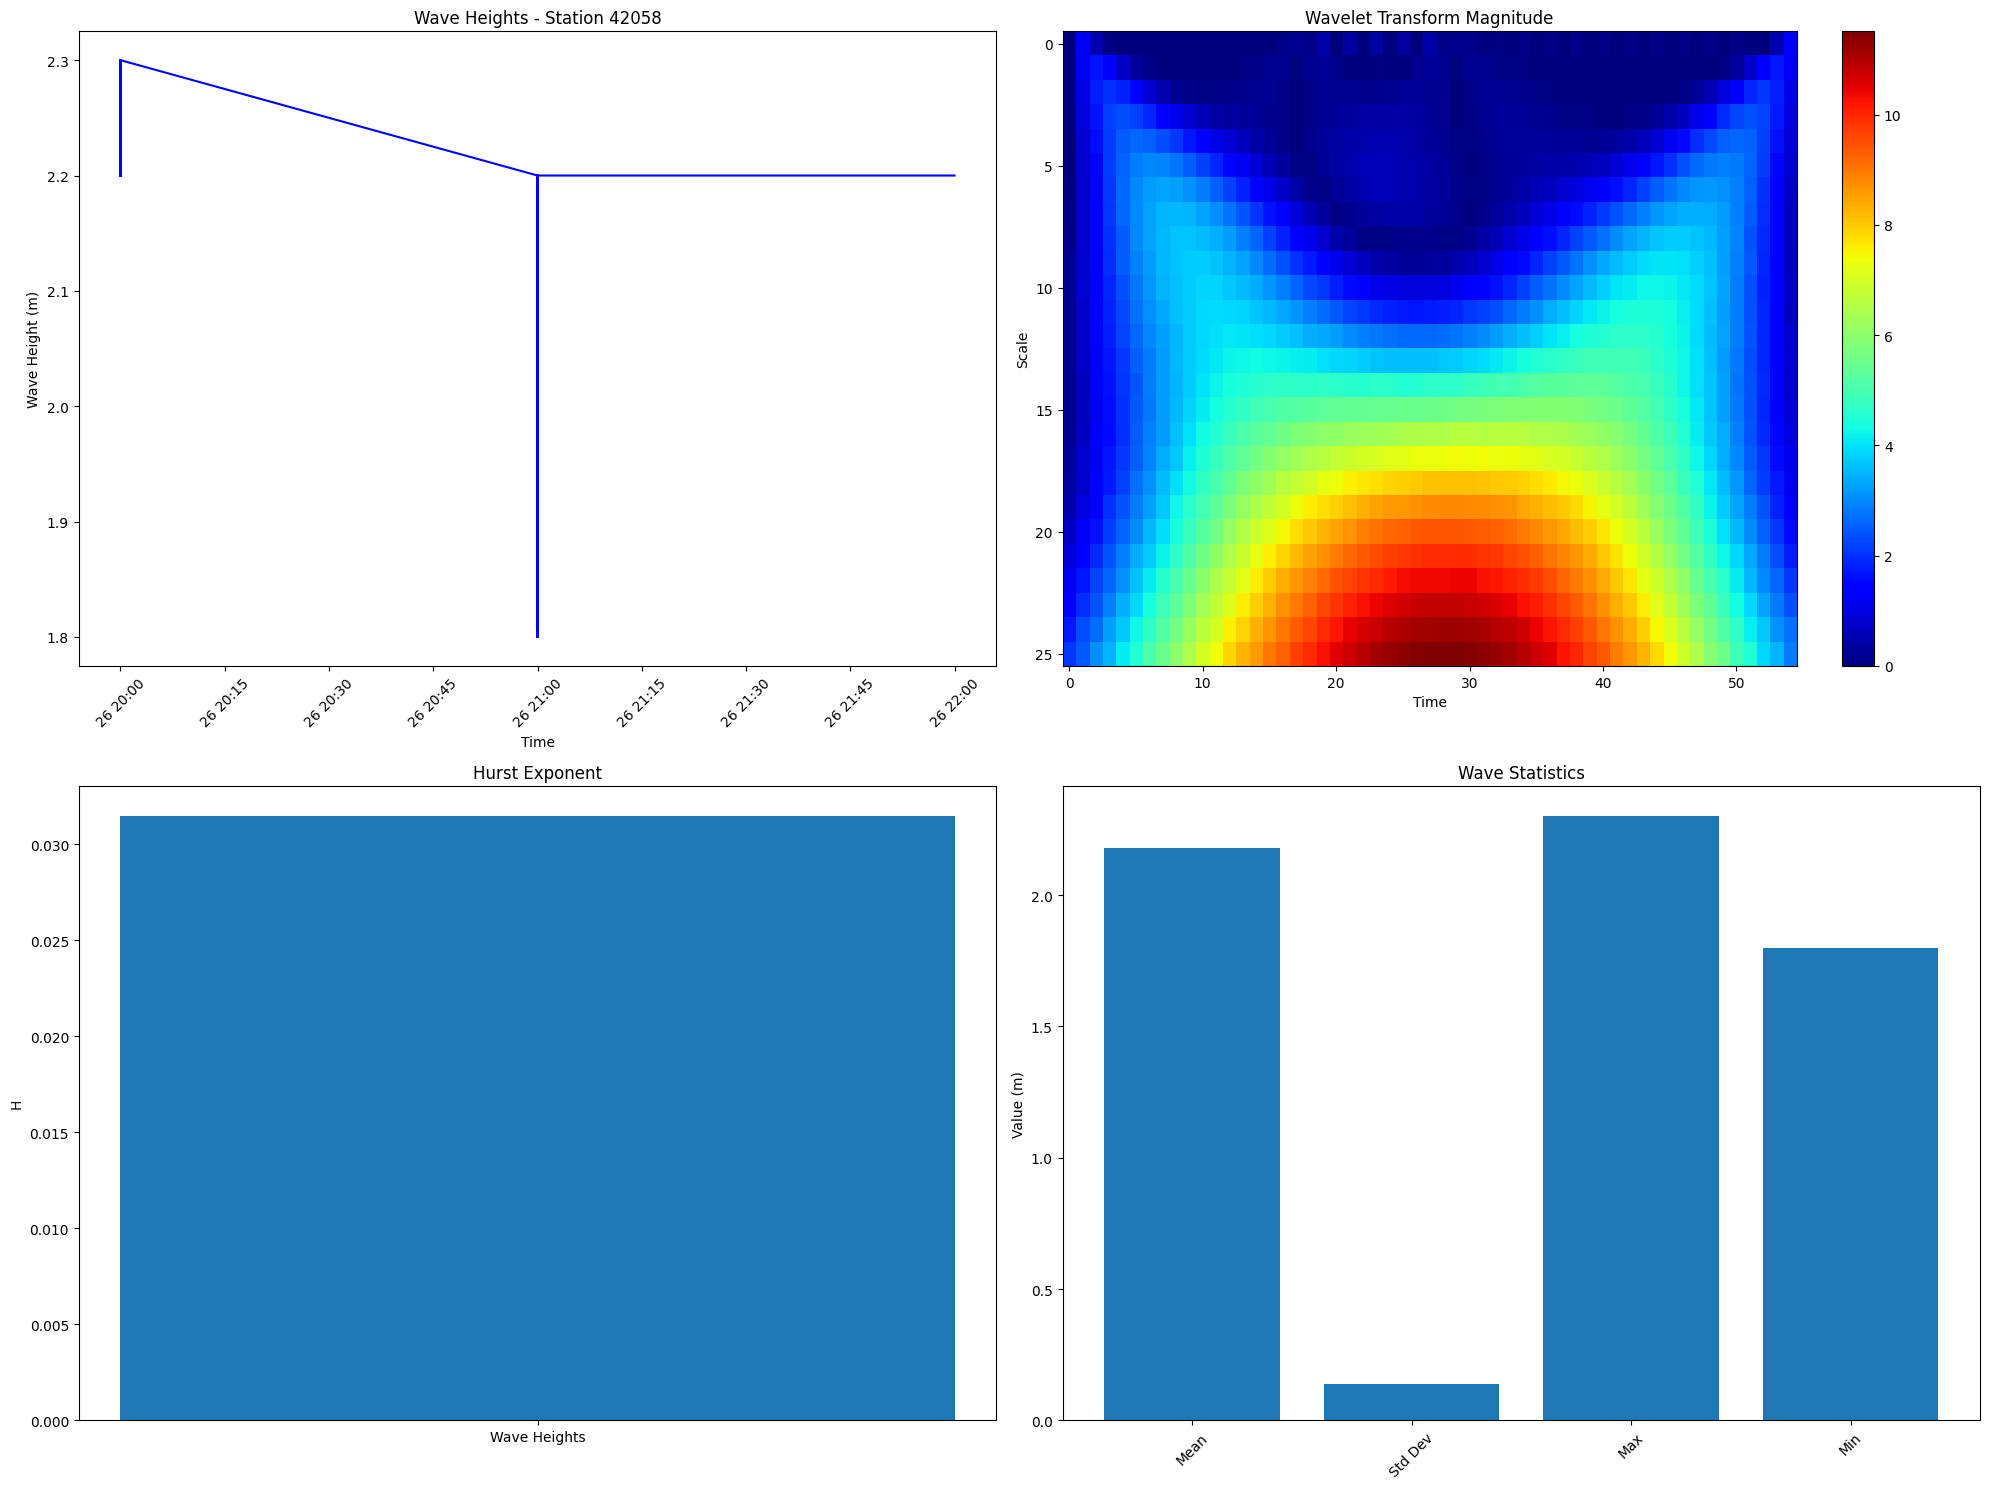


Hurst Exponent (H) for Station 42058: 0.031
Wave patterns show anti-persistent behavior (tendency to reverse)


In [19]:
analyze_station_patterns("42058")

In [20]:
import numpy as np
import pandas as pd
import pywt
from scipy.stats import linregress
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

class WaveAnalyzer:
    """Coastal wave pattern analyzer using fractal methods"""
    
    def __init__(self, wave_data, timestamps):
        self.waves = wave_data
        self.timestamps = timestamps
        self.scaler = StandardScaler()
    
    def calculate_hurst(self, max_lag=20):
        """Calculate Hurst exponent using R/S analysis"""
        lags = range(2, max_lag)
        rs_values = []
        
        for lag in lags:
            rs = []
            for i in range(0, len(self.waves)-lag, lag):
                segment = self.waves[i:i+lag]
                r = np.max(segment) - np.min(segment)
                s = np.std(segment)
                if s > 0:
                    rs.append(r/s)
            if rs:
                rs_values.append(np.mean(rs))
        
        if len(rs_values) > 1:
            return linregress(np.log(lags[:len(rs_values)]), np.log(rs_values))[0]
        return None
    
    def analyze(self):
        """Perform comprehensive wave analysis"""
        # Wavelet transform
        scales = np.arange(1, min(128, len(self.waves)//2))
        coeffs, _ = pywt.cwt(self.waves, scales, 'mexh')
        
        # Calculate Hurst exponent
        hurst = self.calculate_hurst()
        
        # Basic statistics
        stats = {
            'mean': np.mean(self.waves),
            'std': np.std(self.waves),
            'max': np.max(self.waves),
            'min': np.min(self.waves),
            'hurst': hurst
        }
        
        # Visualization
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        
        # Time series
        ax1.plot(self.timestamps, self.waves)
        ax1.set_title('Wave Heights')
        
        # Wavelet transform
        ax2.imshow(np.abs(coeffs), aspect='auto', cmap='jet')
        ax2.set_title('Wavelet Transform')
        
        # Hurst exponent
        ax3.bar(['Hurst Exponent'], [hurst])
        ax3.set_title(f'Hurst: {hurst:.3f}')
        
        # Statistics
        ax4.bar(['Mean', 'Std', 'Max', 'Min'], 
                [stats['mean'], stats['std'], stats['max'], stats['min']])
        ax4.set_title('Wave Statistics')
        
        plt.tight_layout()
        return stats, fig

/var/folders/ty/y5bm7r_s7cj1s6r4zbvt3ty80000gn/T/ipykernel_87639/3151154098.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  timestamps = pd.date_range('2024-01-01', periods=100, freq='H')


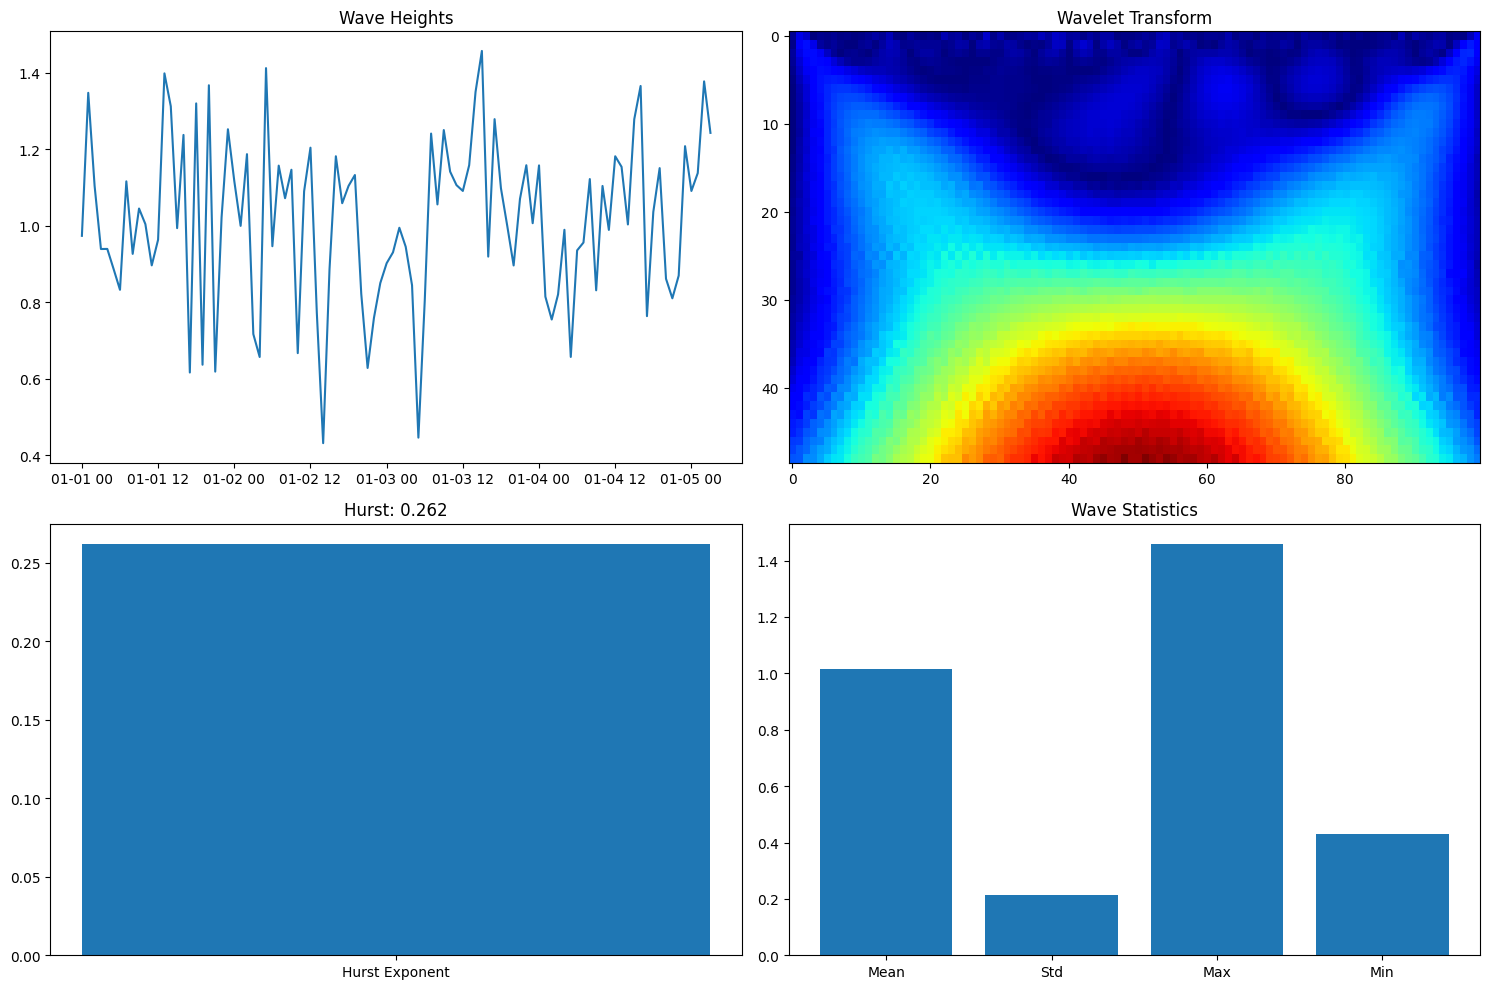

In [13]:
# Example usage
timestamps = pd.date_range('2024-01-01', periods=100, freq='H')
wave_data = np.random.normal(1, 0.2, 100)  # Example data

analyzer = WaveAnalyzer(wave_data, timestamps)
stats, fig = analyzer.analyze()
plt.show()